In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
#import augmentingFiles
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

import numpy as np

In [14]:
seed = 32
np.random.seed(seed)
torch.manual_seed(seed)

# Dataset

In [24]:
train_data = datasets.CIFAR10(
    root="complete-data",
    train=True,
    download=True,
    transform=ToTensor()
)
#train_data[i] is a tuple(3*32*32, label) (C,H,W)
test_data = datasets.CIFAR10(
    root="complete-data",
    train=False,
    download=True,
    transform=ToTensor()
)

Files already downloaded and verified
Files already downloaded and verified


## Visualize the dataset

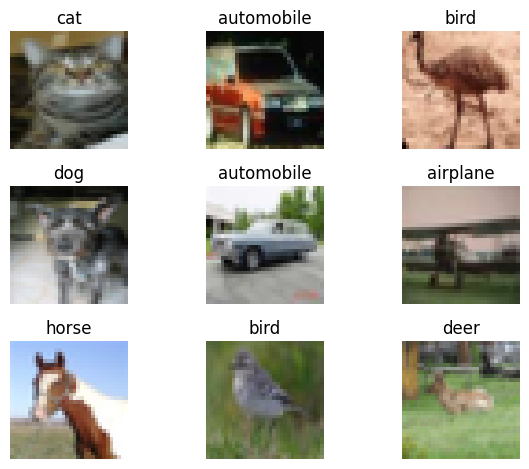

In [4]:
labels={
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}
def visualize_dataset(imgs):
    fig, axes = plt.subplots(3, 3)
    axes=axes.flatten()
    for i, img in enumerate(imgs):
        axes[i].imshow(img[0].permute(1,2,0)) #H,W,C
        axes[i].axis('off')
        axes[i].set_title(labels[img[1]])
    plt.tight_layout()
    plt.show()

rand_indices=np.random.randint(0,len(train_data),size=9)
rand_imgs=[train_data[i] for i in rand_indices]
visualize_dataset(rand_imgs)

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
H=train_data[0][0].shape[1]
W=train_data[0][0].shape[2]

CAT_NUM=10
lr=0.001
batch_size=128
epochs=50

## DataLoader

In [17]:
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# Dataset(small)

In [35]:
from cifair import ciFAIR10
from torchvision import transforms
import numpy as np

train_small_data1=ciFAIR10("small-data", 'train0')
train_small_data2=ciFAIR10("small-data", 'train1')
train_small_data3=ciFAIR10("small-data", 'train2')
test_small_data1=ciFAIR10("small-data", 'val0')
test_small_data2=ciFAIR10("small-data", 'val1')
test_small_data3=ciFAIR10("small-data", 'val2')

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(180),
    transforms.RandomPerspective()
])


class SmallDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        image = torch.tensor(self.images[index], dtype=torch.float32).permute(2, 0, 1)
        label = torch.tensor(self.labels[index], dtype=torch.long)

        if self.transform:
            image = self.transform(image)

        return image, label

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [38]:
images_train=np.concatenate((train_small_data1.data,train_small_data2.data,train_small_data3.data),axis=0)
labels_train=np.concatenate((train_small_data1.targets,train_small_data2.targets,train_small_data3.targets),axis=0)
print(labels_train.shape)
train_data=SmallDataset(images_train,labels_train)
print(train_data.images.shape)
train_data_augmented=SmallDataset(images_train,labels_train,train_transform)
train_data_crop=SmallDataset(train_small_data.data,train_small_data.targets,transform=transforms.RandomCrop(32, padding=4))
train_data_rotate=SmallDataset(train_small_data.data,train_small_data.targets,transform=transforms.RandomRotation(180))
train_data_perspective=SmallDataset(train_small_data.data,train_small_data.targets,transform=transforms.RandomPerspective())


train_data_combined_all=torch.utils.data.ConcatDataset([train_data, train_data_augmented])
train_data_combined_crop=torch.utils.data.ConcatDataset([train_data, train_data_crop])
train_data_combined_rotate=torch.utils.data.ConcatDataset([train_data, train_data_rotate])
train_data_combined_perspective=torch.utils.data.ConcatDataset([train_data, train_data_perspective])

images_test=np.concatenate((test_small_data1.data,test_small_data2.data,test_small_data3.data),axis=0)
labels_test=np.concatenate((test_small_data1.targets,test_small_data2.targets,test_small_data3.targets),axis=0)
test_data=SmallDataset(images_test,labels_test)


(900,)
(900, 32, 32, 3)


In [39]:
batch_size = 64

train_dataloader_small = DataLoader(
    train_data, batch_size=batch_size, shuffle=True)
test_dataloader_small = DataLoader(
    test_data, batch_size=batch_size, shuffle=False)

train_dataloader_augmented = DataLoader(
    train_data_combined_all, batch_size=batch_size, shuffle=True)
test_dataloader_augmented = DataLoader(
    test_data, batch_size=batch_size, shuffle=False)

train_dataloader_crop = DataLoader(
    train_data_combined_crop, batch_size=batch_size, shuffle=True)
test_dataloader_crop = DataLoader(
    test_data, batch_size=batch_size, shuffle=False)

train_dataloader_rotate = DataLoader(
    train_data_combined_rotate, batch_size=batch_size, shuffle=True)
test_dataloader_rotate = DataLoader(
    test_data, batch_size=batch_size, shuffle=False)

train_dataloader_perspective = DataLoader(
    train_data_combined_perspective, batch_size=batch_size, shuffle=True)
test_dataloader_perspective = DataLoader(
    test_data, batch_size=batch_size, shuffle=False)



# CNN model

In [8]:
class CNN(nn.Module):
    def __init__(self,H,W,cat_num):
        super().__init__()
        
        #self.convs=nn.ModuleList([nn.Conv2d(3,16,2,padding=1)]+[nn.Conv2d(i,i*2,3,padding=1) for i in [16,32，64]]) #128
        self.convs=nn.ModuleList([nn.Conv2d(3,32,2,padding=1)]+[nn.Conv2d(i,i*2,3,padding=1) for i in [32,64]])
        self.relu=nn.ReLU()
        self.maxpool=nn.MaxPool2d(2,2)
        self.flatten=nn.Flatten(1,-1)
        self.fc1=nn.Linear(int(128*H*W/(4**3)),256)
        #self.fc2=nn.Linear(256,64)
        self.fc3=nn.Linear(256,cat_num)
        self.dropout=nn.Dropout()
        
        
    def forward(self,x):#x is (batch,channel,H,W)
        for conv in self.convs:
            #print(x.shape)
            x=conv(x)
            
            x=self.relu(x)
            x=self.maxpool(x)
            x=self.dropout(x)
        x=self.flatten(x)
        x=self.dropout(x)
        x=self.relu(self.fc1(x))
        #x=self.relu(self.fc2(x))
        x=self.fc3(x)
        return x


# Training

In [9]:
def train_validation(epochs,train_dataloader,test_dataloader,optimizer,loss_function,model):
    train_losses=[]
    val_losses=[]
    model.to(device)
    for epoch in range(epochs):
        train_loss = 0.0
        val_loss=0.0
        model.train()
        for data in train_dataloader:
            
            #data=data.to(device)
            img,label=data
            img=img.to(device)
            label=label.to(device)
        

            optimizer.zero_grad()
            output = model(img)
            loss = loss_function(output, label)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * img.size(0)
        
        model.eval()
        with torch.no_grad():
            for i, data in enumerate(test_dataloader):
                img,label=data
                img=img.to(device)
                label=label.to(device)
                
                output=model(img)
                loss=loss_function(output,label)
                val_loss+=loss.item()*img.size(0)

        #average loss
        train_loss /= len(train_dataloader.dataset)
        val_loss /= len(test_dataloader.dataset)
        train_losses.append(train_loss)
        val_losses.append(val_loss)   
    #print(train_losses)
    #print(val_losses)     
    plt.semilogy(train_losses, label='Training Loss')
    plt.semilogy(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss curve')
    plt.legend()
    plt.show()



# Result

## Complete dataset (large)
performs well

In [10]:
model=CNN(H,W,CAT_NUM).to(device)
loss_function=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr)

[1.858910287246704, 1.5257693279647828, 1.4137504254913331, 1.3463825687789917, 1.2953115129852295, 1.255119702758789, 1.2180839836502075, 1.1891534101104737, 1.1588962408065795, 1.1457601526641845, 1.1262100654220581, 1.1077252823638917, 1.0997978649902345, 1.0805245737838745, 1.0726108890914916, 1.0534423834609985, 1.0477990149116516, 1.0368841610717774, 1.0316705558395385, 1.0243920532608033, 1.0134527255058288, 1.000494348449707, 0.9937669445800781, 0.9938625067520142, 0.989226768321991, 0.9756465069580078, 0.9714482224655151, 0.9629856895637512, 0.9649540783882141, 0.9585332178878784, 0.9503731643676758, 0.9403467477035522, 0.9473325431632995, 0.9367131935501098, 0.9342933198547363, 0.9275168548965455, 0.9244310087585449, 0.9177875869369507, 0.9133889024734497, 0.9153104852104187, 0.9115925452804565, 0.9081524177932739, 0.8989689524841309, 0.9001023484420776, 0.8911528889656067, 0.8904438006210327, 0.8946144679641723, 0.8901098775863647, 0.8830555059814453, 0.8849590579032898]
[1.

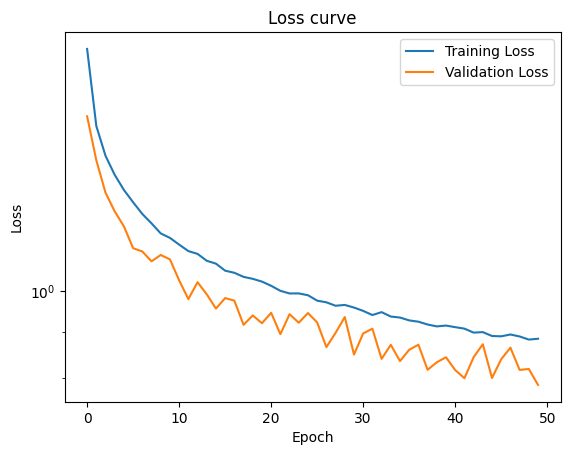

In [27]:
train_validation(epochs,train_dataloader,test_dataloader,optimizer,loss_function,model)

## Small dataset

In [51]:
lr=0.00001
epochs=3000
model_small=CNN(H,W,CAT_NUM).to(device)
loss_function_small=nn.CrossEntropyLoss()
optimizer_small=optim.Adam(model_small.parameters(),lr)

[21.284301435682508, 17.30579517788357, 16.610784242418077, 15.501454811096192, 15.210711460113526, 14.082667350769043, 14.15071061876085, 13.711751107109917, 13.131208970811631, 11.6994439485338, 11.999966053432889, 11.96694428337945, 11.724800673590765, 10.402144546508788, 10.359876234266492, 10.568325911627875, 9.913507050408258, 9.461190274556477, 9.404175495571561, 9.65749232398139, 8.999107602437338, 8.679999237060548, 8.317634523179796, 8.168243158128526, 7.9872808837890625, 7.86581617143419, 7.627251879374186, 7.578028772142198, 7.141871028476292, 7.075660574171279, 7.151138521830241, 6.799961314731174, 6.907888374328613, 6.58710454305013, 6.428461793263753, 6.251514214409722, 6.182682452731663, 5.987085884941949, 5.901061698065864, 5.893282258775499, 5.694676517910428, 5.578362829420302, 5.501817455291748, 5.590619320339627, 5.300483187569513, 5.476454272800022, 5.288520982530382, 5.177529286278618, 4.961799032423231, 4.9159052107069225, 5.302944346533882, 4.959683562384711, 4

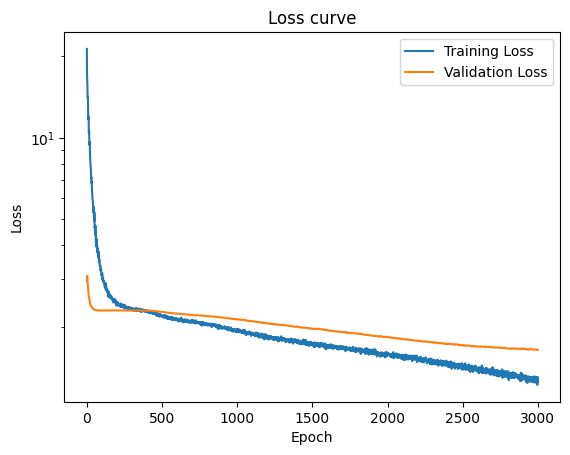

In [52]:
train_validation(epochs,train_dataloader_small,test_dataloader_small,optimizer_small,loss_function_small,model_small)

# Augmented 

## Random Crop

In [53]:
lr=0.00001
epochs=3000
model_crop=CNN(H,W,CAT_NUM).to(device)
loss_function_crop=nn.CrossEntropyLoss()
optimizer_crop=optim.Adam(model_crop.parameters(),lr)
train_validation(epochs,train_dataloader_crop,test_dataloader_crop,optimizer_crop,loss_function_crop,model_crop)

## Random rotate

[31.313952458699543, 26.305693740844728, 24.01952735900879, 23.40909189860026, 21.89575518290202, 20.549219385782877, 19.52511474609375, 18.73297747294108, 18.351515261332192, 17.00364813486735, 16.233375981648763, 15.439089889526366, 15.043256568908692, 13.702603302001954, 13.210665677388508, 13.372069358825684, 12.34599338531494, 11.810653025309245, 10.999526850382487, 10.98888256072998, 10.385715268452962, 10.286164321899413, 9.543776677449545, 9.562326393127442, 9.108905048370362, 8.737726300557455, 8.866706384023031, 8.581721941630045, 8.254601605733235, 8.30581215540568, 7.856787452697754, 7.3505567359924315, 7.110290393829346, 6.929324906667073, 6.578432127634684, 6.770578759511312, 6.234955933888753, 6.061725680033366, 6.344207483927409, 6.083028507232666, 5.925813770294189, 5.906533603668213, 5.536555398305257, 5.741796220143636, 5.570173269907634, 5.359219392140706, 5.084973697662353, 5.022754948933919, 4.958391189575195, 4.983010762532552, 4.982600320180257, 4.88823717753092

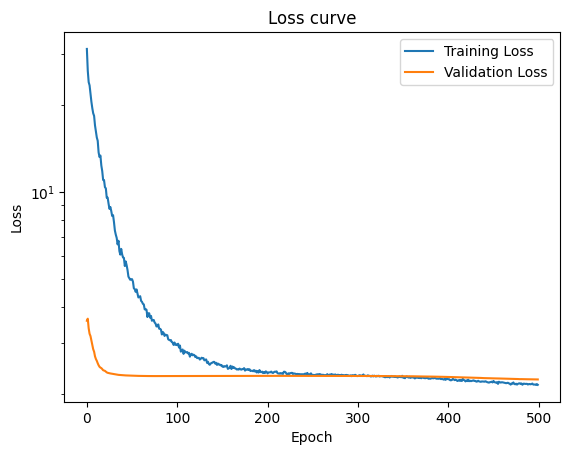

In [46]:
lr=0.00001
epochs=500
model_rotate=CNN(H,W,CAT_NUM).to(device)
loss_function_rotate=nn.CrossEntropyLoss()
optimizer_rotate=optim.Adam(model_rotate.parameters(),lr)
train_validation(epochs,train_dataloader_rotate,test_dataloader_rotate,optimizer_rotate,loss_function_rotate,model_rotate)

## Random Perspective

In [47]:
lr=0.00001
epochs=500
model_perspective=CNN(H,W,CAT_NUM).to(device)
loss_function_perspective=nn.CrossEntropyLoss()
optimizer_perspective=optim.Adam(model_perspective.parameters(),lr)
train_validation(epochs,train_dataloader_perspective,test_dataloader_perspective,optimizer_perspective,loss_function_perspective,model_perspective)

KeyboardInterrupt: 

## Combined

In [ ]:
lr=0.00001
epochs=500
model_combined=CNN(H,W,CAT_NUM).to(device)
loss_function_combined=nn.CrossEntropyLoss()
optimizer_combined=optim.Adam(model_combined.parameters(),lr)
train_validation(epochs,train_dataloader_augmented,test_dataloader_augmented,optimizer_combined,loss_function_combined,model_combined)

[2.312162170410156, 2.31332719039917, 2.3066091957092287, 2.311230838775635, 2.3075053977966307, 2.3077397918701172, 2.3056988220214842, 2.305492401123047, 2.302161808013916, 2.300691005706787, 2.3056947994232178, 2.301251895904541, 2.302909456253052, 2.3029107303619383, 2.3001718044281008, 2.300060453414917, 2.300076988220215, 2.298315641403198, 2.2986316108703613, 2.298512508392334, 2.297951587677002, 2.296529718399048, 2.296602170944214, 2.297784734725952, 2.2954276180267335, 2.300001621246338, 2.29890887260437, 2.2960829849243165, 2.294692859649658, 2.2982310829162595, 2.2997552032470705, 2.2969570713043215, 2.2944287776947023, 2.292106492996216, 2.292279026031494, 2.294589065551758, 2.29667769241333, 2.291602548599243, 2.2929003276824953, 2.292522369384766, 2.2937084007263184, 2.293425268173218, 2.2955138359069824, 2.2860280895233154, 2.294842496871948, 2.2910962181091308, 2.2906422424316406, 2.2949255771636965, 2.291669090270996, 2.286582202911377, 2.288439220428467, 2.2890101585

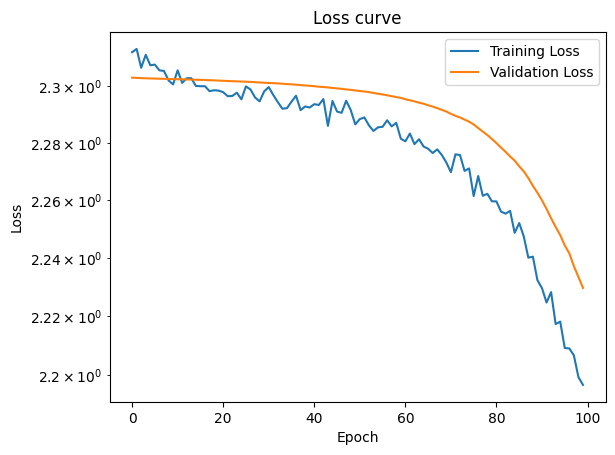

In [31]:
lr=0.00001
epochs=100
model_small=CNN(H,W,CAT_NUM).to(device)
loss_function_small=nn.CrossEntropyLoss()
optimizer_small=optim.Adam(model_small.parameters(),lr)
train_validation(epochs,train_dataloader_small,test_dataloader_small,optimizer_small,loss_function_small,model_small)